# EE-411 Fundamentals of inference and learning, EPFL 
## Exercise Session 6: Ridge Regression and Lasso on real datasets

In this sixth set of exercises, we will see how to implement the methods introduced in the last exercise session and discussed in the last lecture to work with some real datasets. We will see which are the differences between these regularized least-square methods and the standard OLS solution.

**What you will learn today:**  In this sixth notebook, we shall see how to use scikit-learn to implement Ridge and Lasso. We also introduce `pipelines`, an important tool which is frequently used in Machine Learning. Furthermore, we will linger on the important concept of sparsity.

In [1]:
#We import the usual packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# A) Ozone
---
Let us look at a particular real-life data problem. In the following example we take the prediction of ozone concentration as a factor of other weather-based features. As with all data problems, it behooves us to take a look at all of the information that we have about the dataset.

#### Dataset loading

In [19]:
data =   pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/LAozone.data')
data.head()

,ozone,vh,wind,humidity,temp,ibh,dpg,ibt,vis,doy
0,3,5710,4,28,40,2693,-25,87,250,3
1,5,5700,3,37,45,590,-24,128,100,4
2,5,5760,3,51,54,1450,25,139,60,5
3,6,5720,4,69,35,1568,15,121,60,6
4,4,5790,6,19,45,2631,-33,123,100,7


Alright, we're ready to get started ! Now, before we touch anything, we need to follow best practices. When faced with a new dataset, we need to split it into three parts: **Training**(and within that, **Validation**), and **Testing** sets. 

The best practice here is to take the test data and lock it away somewhere. It is always tempting to tune your algorithms to give the best test performance. However, even if the regression isn't explicitly *trained* on the test data, as practitioners, we could be continually making changes in an effort to get our numbers up.

Instead, we should deep-freeze the test data, and then tune as much as we can via **cross-validation (CV)** on our training data.

#### Train/Test splitting

In [5]:
from sklearn.model_selection import train_test_split

#--- Convert from DataFrame to NDArray ---#
# We also ensure that we load in all data as floating point values
# so that we don't miss anything to truncations.
y = data['ozone'].to_numpy().astype(float)
X = data[data.columns[1:]].to_numpy()

#--- Split Dataset ---#
XTrain, XTest, yTrain, yTest = train_test_split(X,y,test_size = 0.25, random_state=1)

print("Training Samples: ", len(yTrain))
print("Testing  Samples: ", len(yTest))

Training Samples:  247
Testing  Samples:  83


Now, before we start attempting to fit models, lets take a bit of care and apply some pre-processing to our dataset. The de-facto pre-processing is *centering and normalization*. Specifically, many flavors of estimators (OLS, RR, etc.) can be thrown off by large differences in scale and variations between the features. We can easily account for this in our estimators by simply normalizing the feature columns and removing averages. Scikit-Learn has some features to do this automatically!

#### Preprocessing

In [6]:
from sklearn import preprocessing

#--- Scaling ---#
scaler = preprocessing.StandardScaler().fit(XTrain)
XTest_scaled = scaler.transform(XTest)
XTrain_scaled = scaler.transform(XTrain)

#--- Center observations (simplify the OLS)---#
yTrain_mean = np.mean(yTrain)
yTrain_centered = yTrain - yTrain_mean

Now it is time for us to choose our estimator. What should we choose? 

## Attempt 1: ordinary least squares (OLS)
---



If you remember last exercise session, the equation to solve is of the type

$$
(X^T X) \hat {\mathbf w} = X^T {\mathbf y}
$$

The function `linalg.solve(a,b)` can be used to solve a system of linear scalar equations $ax=b$, thus we can use it to compute the prediction of the model both on the train and on the test datasets

In [7]:
#--- Compute the OLS Estimate ---#
regOLS = np.linalg.solve(np.dot(XTrain_scaled.T,XTrain_scaled), np.dot(XTrain_scaled.T,yTrain_centered))

yp = np.dot(XTrain_scaled, regOLS)
ypTest = np.dot(XTest_scaled, regOLS)

Let's see now how well the prediction performance looks and which are the learned parameters corresponding to the OLS solution

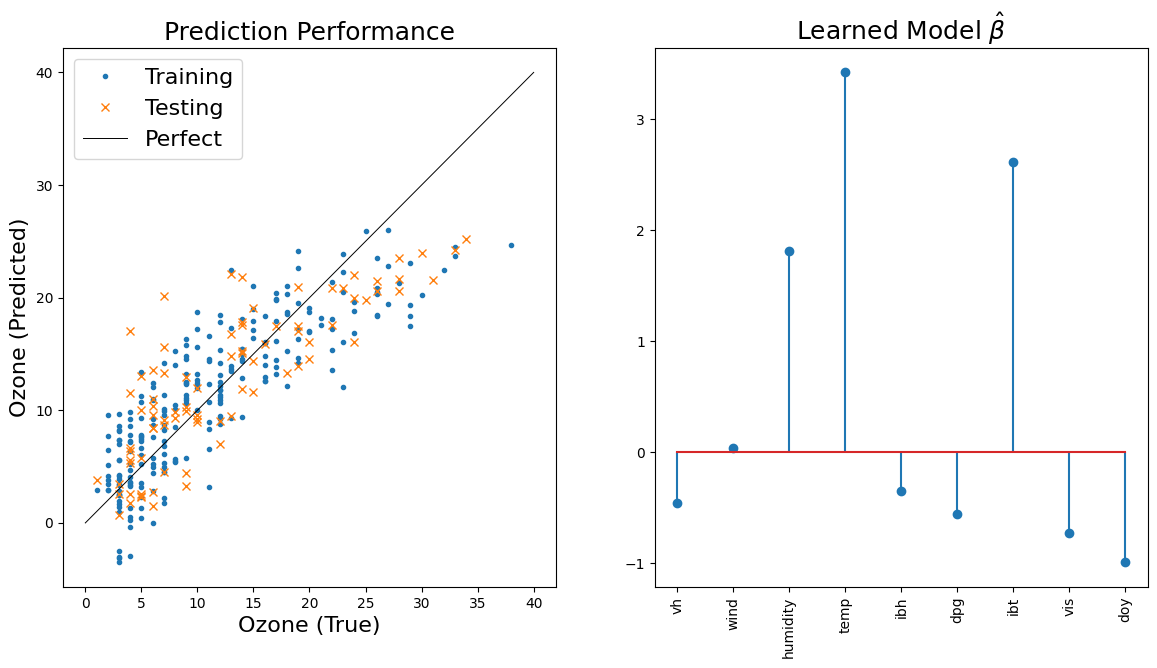

In [8]:
#--- Visualize ---#
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(yTrain, yp + yTrain_mean,'.', label='Training') #remember to add again the mean when you plot
plt.plot(yTest, ypTest + yTrain_mean, label='Testing', marker='x', ls='')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
# plt.axis([0, 40, 0, 40])
plt.xlabel('Ozone (True)', fontsize=16)
plt.ylabel('Ozone (Predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.title('Prediction Performance', fontsize=18)
# Plot the learned model
plt.subplot(122)
plt.stem(regOLS)
plt.title('Learned Model $\\hat{\\beta}$', fontsize=18)
plt.xticks(range(9),data.keys()[1:10], rotation='vertical');

Finally, to see how well the model is performing, we can compute the Residual Sum of Squares (RSS) for both the train and the test set

In [9]:
#--- Print RSS ---#
rss_train = np.mean(np.power(yTrain_centered - yp,2))
rss_test = np.mean(np.power(yTest - yTrain_mean - ypTest,2))
print("Normalized RSS (Train): %0.2f" % rss_train)
print("Normalized RSS  (Test): %0.2f" % rss_test)

Normalized RSS (Train): 18.28
Normalized RSS  (Test): 22.53


The same thing could have been done using the packages present in **Scikit-Learn**

In [10]:
from sklearn import linear_model

#--- Define OLS Estimator ---#
regL = linear_model.LinearRegression()
#--- Fit the parameters ---#
regL.fit(XTrain_scaled,yTrain_centered)
#--- Use the learned coefficients to predict the y ---#
yp_L = regL.predict(XTrain_scaled)
ypTest_L = regL.predict(XTest_scaled)

**Note:** the standard value `fit_intercept=True` in `LinearRegression`, but also in `Ridge` and in `Lasso`, allows us not to think about the intercept, since it is automatically considered by the method.

#### 1) Compare these estimates to the preivious ones, computed without considering the intercept. Why they are so similar?
 - Is the intercept fitted by `LinearRegression` big? 
 - What's the difference in the MSE of the two prediction?
 - (bonus) Make a plot!

#### 2) Prove that fitting the intercept (as `LinearRegression`) is equivalent to what we did (subtracting the mean). (Hint: remember that the inpunts are scaled!)

## Attempt 2: Ridge Regression
---

For RR, that we implemented by hand in the last notebook, we can use directly Scikit-learn. First of all, we import as always the model, choosing for now the regularization constant $\alpha = 0.01$

In [11]:
#--- Define Regression Estimator ---#
regRR = linear_model.Ridge(alpha=0.01)

Now, we need to perform some kind of cross-validation (CV) to find the best set of parameters for our model. We will do this by constructing a **Pipeline**. A pipeline is a useful way of handling pre-processing on separate data partitions when performing CV. Let's take a look at that.

In the next cell we use the pipeline to do two things:

* We standardize features by removing the mean and scaling to unit variance (it is done by `preprocessing.StandardScaler()`)

* We implement the fitting strategy; namely Ridge Regression

#### Pipeline

In [25]:
from sklearn.pipeline import make_pipeline 

#--- Make a Pre-processing + Fitting Pipeline ---#
pipe_regRR = make_pipeline(preprocessing.StandardScaler(), regRR)

After that, we have  to define a Scoring Metric. In this case, to compare the fits we look at the prediction error via the RSS.

In [29]:
#--- Define a Scoring Metric (Residual Sum of Squares) ---#
def neg_rss(reg, X, y):
    yp = reg.predict(X)
    return -np.mean(np.power(y - yp,2))

 We can then create an iterator which performs a set of **randomized splits on the dataset into "train" and "validation"**. 
 
Obviously, we have a trade-off between the test set size and the number of splits we should perform.

In [27]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

#--- Define CV Splitting ---#
cv = ShuffleSplit(n_splits=30, test_size=0.05, random_state=1)

#--- Define the Parameters to Search ---#
param_grid = [
    {'ridge__alpha': np.logspace(-5,3,100)} # we do CV for values of alpha between 0.0001 and 1000
]

Finally, we use `GradSearchCV` to find which is the best value of the parameter $\alpha$

In [16]:
#--- Define CV ---#
cv_regRR = GridSearchCV(pipe_regRR, param_grid, scoring=neg_rss, cv=cv,return_train_score=True) #Note that we need to use the RSS with a minus sign!

In [ ]:
#--- Run CV ---#
cv_regRR.fit(XTrain,yTrain)

Great! Now lets take a look at the performance of our estimator. Here, for example of Ridge regression, we chart over the $\alpha$ parameter that we perform CV against.

First of all, we save in `cvOptAlpha` the optimal regularization parameter $\alpha$ found by the grid search, and in `cvOptParams` the corresponding parameters

In [32]:
#--- Record CV Optimizing Hyper-Params ---#
cvOptAlpha = cv_regRR.cv_results_['param_ridge__alpha'][cv_regRR.best_index_]
cvOptParams = cv_regRR.best_estimator_['ridge'].coef_

In [33]:
cvOptAlpha

12.91549665014884

Then, we can plot the performance versus the regularization parameter $\alpha$

In [ ]:
#--- Visualize ---#
testedAlpha = cv_regRR.cv_results_['param_ridge__alpha']
trainScores = -cv_regRR.cv_results_['mean_train_score']   # Reverse Sign
testScores = -cv_regRR.cv_results_['mean_test_score']    # Reverse Sign

plt.figure(figsize=(15,5))
plt.plot(testedAlpha, trainScores, '-', label='Training (Avg.)')
plt.plot(testedAlpha, testScores, '-', label='Validation (Avg.)')
plt.xlabel('Regularization Parameter $\\alpha$', fontsize=16)
plt.ylabel('$\\frac{1}{N}RSS$', fontsize=16)
plt.axvline(cvOptAlpha, label='$\\alpha^*$', color='k', linestyle=':')
plt.xscale('log')
plt.xlim([0.9*1e-3, 1e3])
plt.yscale('log')
plt.tight_layout()
plt.legend(loc=2, fontsize=16)

Now, lets take a look at how well we are able to make our predictions on the training set using this CV optimal value of $\alpha$.

In [ ]:
#--- Get Training Predicitions ---#
pipe_regRR.set_params(ridge__alpha=cvOptAlpha) # !!! how to pass parameters to pipelines
pipe_regRR.fit(XTrain, yTrain)
yp = pipe_regRR.predict(XTrain)

#--- Visualize ---#
plt.figure(figsize=(7,7))
plt.plot(yTrain, yp, '.', label='Training (CV-Opt)')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
# plt.axis([0, 40, 0, 40])
plt.xlabel('Ozone (True)', fontsize=16)
plt.ylabel('Ozone (Predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16);

And now, finally, we are ready to take our test data out of deep-freeze. How did we do?

#### 3) Plot, as we previously did for OLS, the prediction performance and the learned parameters. After having done that, compute the RSS and compare it to the OLS one

## Attempt 3: Lasso
---


### 4) Your turn: using the `linear_model.Lasso` estimator present in Scikit-Learn,  repeat the steps done for Ridge Regression:
* Create the pipeline for preprocessing + regressor
* Do the Grid Search to find the optimal regularization parameter
* Visualize how the performance varies when we change the regularization parameter 
* Plot the prediction performance and the learned parameters. What do you observe?
* Compute the RSS and compare it to the RR and the OLS one.

# B) Diabetes

We will now perform some numerical experiments with the Diabetes Dataset trying to predict diabetes outcomes one year forward. This is a classical dataset in statistics, and more information can be found at <a href="https://archive.ics.uci.edu/ml/datasets/Diabetes">https://archive.ics.uci.edu/ml/datasets/Diabetes</a>. Here is what we have: 10 baseline variables: age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of $n = 442$ diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.

Our first goal is to plot the weights for each value of $\lambda$ for Ridge Regression and LASSO. This is called a **regularization path**.

We first load the dataset

In [20]:
from sklearn import datasets

number_examples=200
diabetes = datasets.load_diabetes()
X = diabetes.data[:number_examples]
y = diabetes.target[:number_examples]

In [21]:
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


### 5) Using the pipelines `pipe_regRR` and `pipe_regLasso` constructed before for the Ozone problem:

* Divide the dataset such that you have 150 training samples and 50 test samples
* Do the Grid Search to find the optimal regularization parameters, for $\alpha$ in $[10^{-2},10^5]$
* Visualize how the performance varies when we change the regularization parameter, comparing Rindge and Lasso

### 6) Then aswer to these questions [EVALUATED]:
- What do the points $\alpha=0$  and  $\alpha = +\infty$  correspond to? Why for these values both the regularizations give the same result?

- What is the qualitative difference between the LASSO path and Ridge Path? (Plot it as well in linear scale)

In [22]:

XTrain, XTest, yTrain, yTest = train_test_split(X,y,test_size = 0.25, random_state=1)

print("Training Samples: ", len(yTrain))
print("Testing  Samples: ", len(yTest))

Training Samples:  150
Testing  Samples:  50


In [31]:
pipe_regRR = make_pipeline(preprocessing.StandardScaler(), regRR)
param_grid = [
    {'ridge__alpha': np.logspace(-2,5,100)}
]

cv_regRR = GridSearchCV(pipe_regRR, param_grid, scoring=neg_rss, cv=cv,return_train_score=True)
cv_regRR.fit(XTrain,yTrain)

# Do the same with Lasso
reg_lasso = linear_model.Lasso(alpha=0.01)
pipe_reg_lasso = make_pipeline(preprocessing.StandardScaler(), reg_lasso)
param_grid = [
    {'lasso__alpha': np.logspace(-2,5,100)}
]

cv_reg_lasso = GridSearchCV(pipe_reg_lasso, param_grid, scoring=neg_rss, cv=cv, return_train_score=True)
cv_reg_lasso.fit(XTrain,yTrain)




GridSearchCV(cv=ShuffleSplit(n_splits=30, random_state=1, test_size=0.05, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('lasso', Lasso(alpha=0.01))]),
             param_grid=[{'lasso__alpha': array([1.00000000e-02, 1.17681195e-02, 1.38488637e-02, 1.62975083e-02,
       1.91791026e-02, 2.25701972e-02, 2.65608778e-02, 3.12571585e-02,
       3.67837977e-02,...
       4.53487851e+03, 5.33669923e+03, 6.28029144e+03, 7.39072203e+03,
       8.69749003e+03, 1.02353102e+04, 1.20450354e+04, 1.41747416e+04,
       1.66810054e+04, 1.96304065e+04, 2.31012970e+04, 2.71858824e+04,
       3.19926714e+04, 3.76493581e+04, 4.43062146e+04, 5.21400829e+04,
       6.13590727e+04, 7.22080902e+04, 8.49753436e+04, 1.00000000e+05])}],
             return_train_score=True,
             scoring=<function neg_rss at 0x000001B8752F1080>)

In [38]:
cvOptAlpha_RR  = cv_regRR.cv_results_['param_ridge__alpha'][cv_regRR.best_index_]
cvOptParams_RR = cv_regRR.best_estimator_['ridge'].coef_

cvOptAlpha_lasso  = cv_reg_lasso.cv_results_['param_lasso__alpha'][cv_reg_lasso.best_index_]
cvOptParams_lasso = cv_reg_lasso.best_estimator_['lasso'].coef_

print(f"Ridge: {cvOptAlpha_RR}")
print(f"Lasso: {cvOptAlpha_lasso}")

Ridge: 12.91549665014884
Lasso: 1.3219411484660286


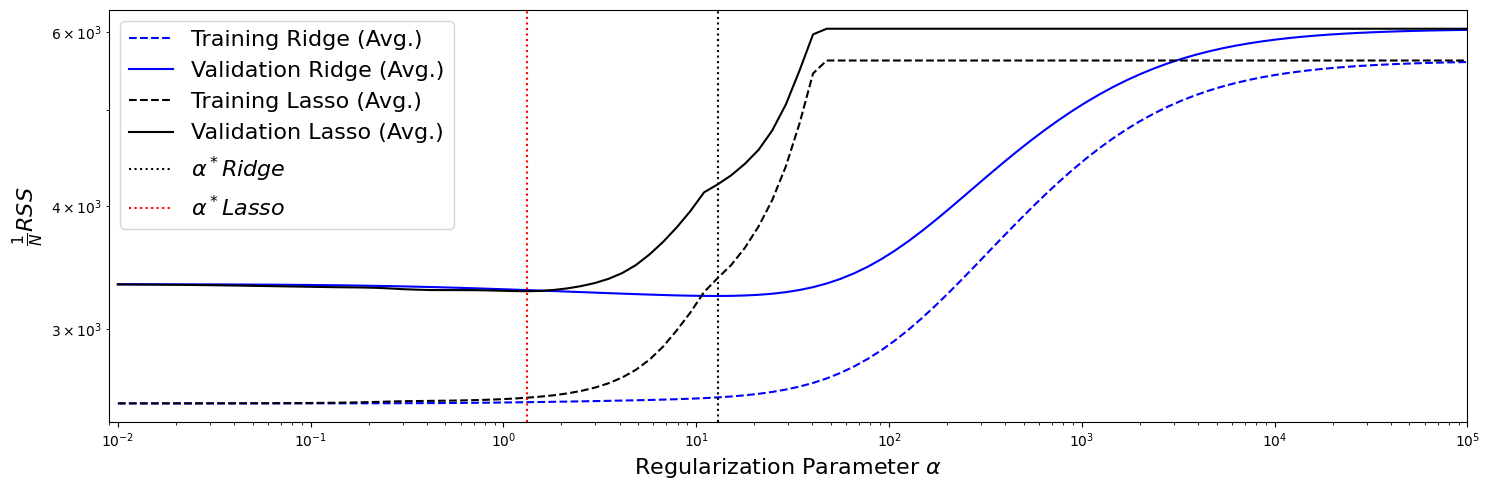

In [43]:
testedAlpha_RR = cv_regRR.cv_results_['param_ridge__alpha']
trainScores_RR = -cv_regRR.cv_results_['mean_train_score']   # Reverse Sign
testScores_RR = -cv_regRR.cv_results_['mean_test_score']    # Reverse Sign

testedAlpha_lasso = cv_reg_lasso.cv_results_['param_lasso__alpha']
trainScores_lasso = -cv_reg_lasso.cv_results_['mean_train_score']   # Reverse Sign
testScores_lasso = -cv_reg_lasso.cv_results_['mean_test_score']    # Reverse Sign

plt.figure(figsize=(15,5))
plt.plot(testedAlpha_RR, trainScores_RR, '--', color = 'blue',label='Training Ridge (Avg.)')
plt.plot(testedAlpha_RR, testScores_RR, '-',color = 'blue', label='Validation Ridge (Avg.)')
plt.plot(testedAlpha_lasso, trainScores_lasso, '--', color = 'black' ,label='Training Lasso (Avg.)')
plt.plot(testedAlpha_lasso, testScores_lasso, '-', color = 'black', label='Validation Lasso (Avg.)')
plt.xlabel('Regularization Parameter $\\alpha$', fontsize=16)
plt.ylabel('$\\frac{1}{N}RSS$', fontsize=16)
plt.axvline(cvOptAlpha_RR, label='$\\alpha^* Ridge$', color='k', linestyle=':')
plt.axvline(cvOptAlpha_lasso, label='$\\alpha^* Lasso$', color='r', linestyle=':')
plt.xscale('log')
plt.xlim([0.9*1e-2, 1e5])
plt.yscale('log')
plt.tight_layout()
plt.legend(loc=2, fontsize=16)

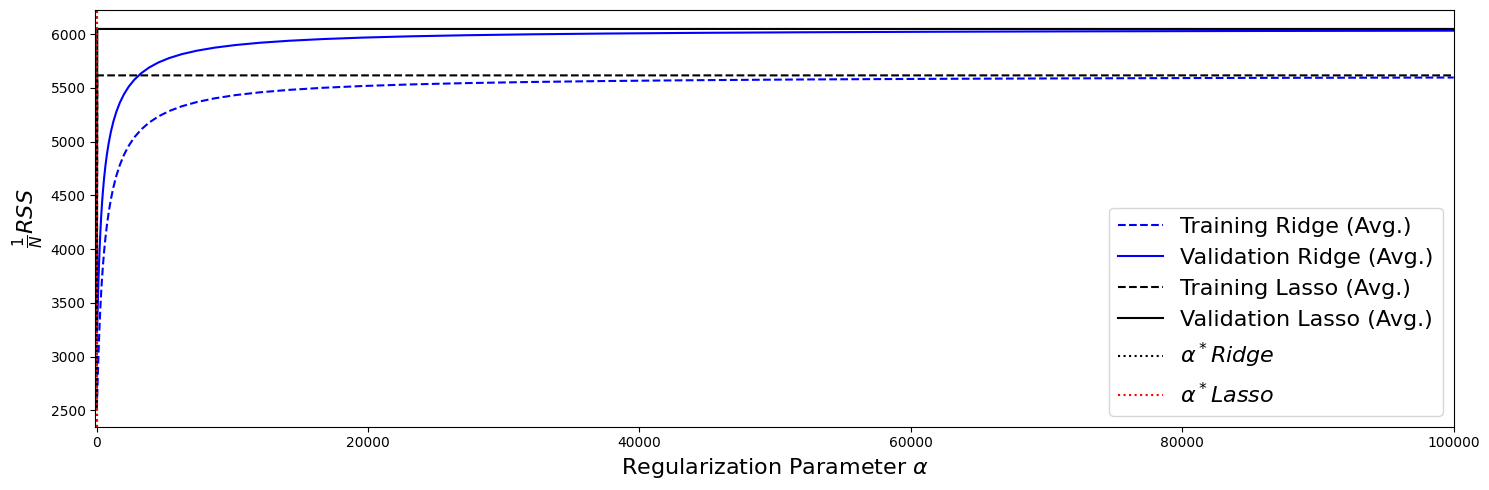

In [49]:
plt.figure(figsize=(15,5))
plt.plot(testedAlpha_RR, trainScores_RR, '--', color = 'blue',label='Training Ridge (Avg.)')
plt.plot(testedAlpha_RR, testScores_RR, '-',color = 'blue', label='Validation Ridge (Avg.)')
plt.plot(testedAlpha_lasso, trainScores_lasso, '--', color = 'black' ,label='Training Lasso (Avg.)')
plt.plot(testedAlpha_lasso, testScores_lasso, '-', color = 'black', label='Validation Lasso (Avg.)')
plt.xlabel('Regularization Parameter $\\alpha$', fontsize=16)
plt.ylabel('$\\frac{1}{N}RSS$', fontsize=16)
plt.axvline(cvOptAlpha_RR, label='$\\alpha^* Ridge$', color='k', linestyle=':')
plt.axvline(cvOptAlpha_lasso, label='$\\alpha^* Lasso$', color='r', linestyle=':')
# plt.xscale('log')
plt.xlim([-100, 10**5])
# plt.yscale('log')
plt.tight_layout()
plt.legend(loc='lower right', fontsize=16)

Optimum $\alpha$ for Lasso is lower than for Ridge.

RSS of Lasso starts increasing before than for Ridge.

For very low and very high values of $\alpha$ they are the same

# Question 6

- $\alpha = 0$ means that we do not take any regularization, so we are simply performing a standard OLS regression for both Ridge and Lasso, and that is why they are equal.
$\alpha = \infty$ means that the regularization factor prevails on the OLS term. The result is that the minimization of the cost function pushes the $\omega$ values to 0 to counteract the infinite value of $\alpha$. Again, this happens regardless of the regularization methods and so Lasso and Ridge are equal
- Both in the log scale and linear scale paths we see that Lasso saturates to the maximum value of RSS before. So the L2 regularization of Ridge dampens the effect of the penalization and the transition to the saturation value in smoother.

# Classification with Logistic regression and SVM 

**What you will learn today**: You will learn how to implement a classifier. First we will analyze a toy example in which we will use a logistic classifier coded from scratch. Once we understood the logic behind the algorithm we will use the black box Sklearn one for recognizing hand-written digits. You will also implement SVM classifier on a different dataset to get familiar with this important family of algorithm.

# 1) Logistic regression from scratch

Let us generate a synthetic dataset using a multivariate Gaussian distribution

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
num_observations = 500

x1 = np.random.multivariate_normal([0, 0], [[1, .5],[.5, 1]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .8],[.8, 1]], num_observations)

dataset = np.vstack((x1, x2)).astype(np.float32)
labels = np.hstack((np.zeros(num_observations),np.ones(num_observations)))

dataset[:5]

Let's plot our data

In [ ]:
plt.figure(figsize=(14,8))
plt.xlim(-3,4)
plt.scatter(dataset[:, 0], dataset[:, 1],c = labels, alpha = .4)

Our goal is to use a logistic function to fit our dataset. In this case:
$$P_{\rm model}(y_i|{\vec w} \cdot {\vec x_i}) = \frac {e^{({\vec w} \cdot {\vec x_i})y_i}}{1+\exp({\vec w} \cdot {\vec x_i})}$$
such that
$$P_{\rm model}(y_i=1)  = \frac {\exp{({\vec w} \cdot {\vec x_i})}}{1+\exp({\vec w} \cdot {\vec x_i})}  = \frac {1}{1+\exp(-{\vec w} \cdot {\vec x_i})}~~~ \text{and}~~~ P_{\rm model}(y_i=0)  = \frac {1}{1+\exp({\vec w} \cdot {\vec x_i})}  = \frac {\exp{(-{\vec w} \cdot {\vec x_i})}}{1+\exp(-{\vec w} \cdot {\vec x_i})}$$


Now, we can either use the cross-entropy loss and write:
$$\mathcal{L}(\vec{w}) = - \sum_{i=1}^n \sum_{y_i=0,1} y_i \log P_{\rm model}(y_i) +  (1-y_i) \log (1 - P_{\rm model}(y_i)) $$
or equivalently write a maximum-likelihood problem with
$$
\mathcal{L}(\vec{w}|\vec{\bm{x}},\bm{y}) \propto \sum_i \log P_{\rm model}(y_i|{\vec w} \cdot {\vec x_i})
$$
In both cases, the problem boils down to minimizing the following loss:
$$\mathcal{L}(\vec {w}) =  \sum_{i=1}^n - y_i {\vec {w}} \cdot {\vec x}_i  + \log{(1+\exp({\vec w} \cdot {\vec x}_i ))} $$

Let us implement these function:

In [33]:
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))
def log_loss(features, target, weights): 
    scores = np.dot(features, weights)
    ll = np.sum( -target*scores + np.log(1 + np.exp(scores)) )
    return ll

In order to perform optimization, we need to compute the gradient and perform gradient descent. Here we have:

$$\nabla_{\vec w} \mathcal{L}(\vec w) =  \sum_{i = 1}^n - y_i  {\vec x}_i  + {\vec x}_i  \frac{\exp({\vec w} \cdot {\vec x}_i )}{(1+\exp({\vec w} \cdot {\vec x}_i ))} = - \sum_{i = 1}^n {\vec x}_i^T (y_i - P(y_i=1)) $$

We can now write the  logistic regression

##### **Exercise 1**

##### Try writing Gradient Descent using this Loss, as we did in the previous exercise session

# 2) Logistic regression on real dataset 



Let us use the fantastic notebooks from https://physics.bu.edu/~pankajm/MLnotebooks.html, a terrific book for ML newcomers especially if they come from physics. We will consider again our friend MNIST, remember the lecture on KNN? First a bit of history on this famous dataset:


The MNIST classification problem is one of the classical ML problems for learning classification on high-dimensional data with a fairly sizable number of examples (60000). Yann LeCun and collaborators collected and processed $70000$ handwritten digits (60000 are used for training and 10000 for testing) to produce what became known as one of the most widely used datasets in ML: the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Each handwritten digit comes in a grayscale square image in the shape of a $28\times 28$ pixel grid. Every pixel takes a value in the range $[0,255]$, representing $256$ nuances of the gray color. The problem of image classification finds applications in a wide range of fields and is important for numerous industry applications of Machine Learning.

 ### SoftMax regression:
 Before we consider two possible labels for our data, you can easily guess that it is amenable to have more than one in this case. 

 Do not worry! We can easily generalize what we said before. 


We will use SoftMax regression, which can be thought of as a statistical model which assigns a probability that a given input image corresponds to any of the 10 handwritten digits. The model is a generalization of the logistic regression and reads:
$$
p(y_i=j|\vec{x}_i;\vec{w}) = \frac{e^{-\vec{w}_j^T \vec{x}}}{\sum_{k=0}^9 e^{-\vec{w}_k^T\vec{x} }},
$$
Where $p(y_i=j|\vec{x}_i;\vec{w})$ is the probability that input $\vec{x}_i$ is the $j$-th digit, $j\in[0,9]$.
The model also has 10 weight vectors $\vec{w}_j$ which we will train below. Finally, one can use this information for prediction by taking the value of $y_i$ for which this probability is maximized:
\begin{align}
y_{pred}=\arg\max_i p(y=i|\vec{x})
\end{align}

First thing to do is to import the dataset and preprocess the data:


In [ ]:
import time


from sklearn.datasets import fetch_openml # MNIST data
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

print(__doc__)

# Turn down for faster convergence
train_size = 60000
test_size = 10000

### load MNIST data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)


In [43]:
X = np.asarray(X)
y = np.asarray(y)

Let's plot an image to see how it looks like with plt.imshow.

In [ ]:
plt.imshow(X[2,:].reshape(28,28))
y[2]

We shuffle the data and we do the test-train splitting.

In [45]:
# shuffle data
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))
# pick training and test data sets 
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_size,test_size=test_size)

We preproccess the data and use StandardScaler to have zero mean and unit variance. Pay attention that we do that only on the training set!

In [46]:
# scale data to have zero mean and unit variance [required by regressor]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

**Exercise** 
 1. You need to learn how to read a Python documentation. Search on the internet how to implement softmax regression.
 2. Fix the value of the regularization to be $10^{-5}$. Fit the data and compute two quantities: 
   - Sparsity of the weights (percentage of non-zero weights)
   - Score (i.e. accuracy)

# 3) SVM Classification on real dataset 


**Exercise**
 1. Repeat what you did for softmax regression for an Support Vector Machine (SVM) linear classifier.
 2. Go and search the Python doc for SVM classifier. Choose the linear one (we will see other in following lectures)
 3. Fit the data using the default value of regularization and compare with an optimized value using CV.

Clear and friendly reference can be found here: https://www.kaggle.com/nishan192/mnist-digit-recognition-using-svm. 

PS: If you do not know Kaggle, you should check it out!